In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
work_dir = os.curdir
data_dir = os.path.join(work_dir,'datasets')
log_dir = os.path.join(work_dir,'logs')

In [3]:
def LoadData():
    (X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
    X_train = tf.constant(X_train,dtype='float32')
    X_test = tf.constant(X_test,dtype='float32')
    y_train = tf.constant(y_train,dtype='float32')
    y_test = tf.constant(y_test,dtype='float32')
    return ((X_train,y_train),(X_test,y_test))

In [4]:
(X_train,y_train),(X_test,y_test) = LoadData()

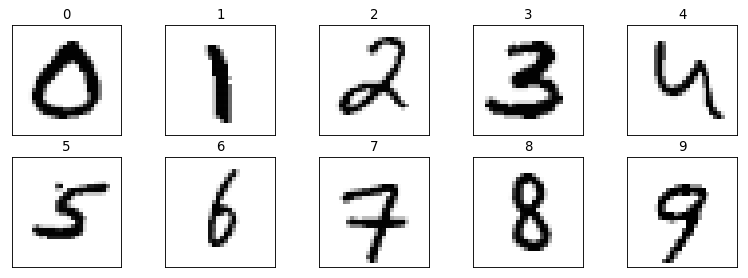

In [5]:
fig,ax = plt.subplots(nrows=2,ncols=5,figsize=(12,4),dpi=80)
for i in range(2):
    for j in range(5):
        dig = i*5 + j
        bool_list = (y_train == dig)
        idx = np.random.randint(low=0,high=1000)
        X_sample = X_train[bool_list][idx]
        y_sample = y_train[bool_list][idx]
        ax[i][j].imshow(np.array(X_sample),cmap='Greys')
        ax[i][j].title.set_text(dig)
        ax[i][j].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
        ax[i][j].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

In [81]:
class MyNormalizationLayer(tf.keras.layers.Layer):
    def __init__(self,epsilon=0.0001,**kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        
    def build(self,batch_input_shape):
        self.alpha = tf.Variable(np.ones(shape=batch_input_shape[-1:]),dtype='float32')
        self.beta = tf.Variable(np.zeros(shape=batch_input_shape[-1:]),dtype='float32')
    
    def call(self,inputs):
        if len(inputs.shape) == 1:
            mu,var = tf.nn.moments(inputs, axes=0, keepdims=True)
        else:
            mu,var = tf.nn.moments(inputs, axes=1, keepdims=True)
        std = tf.math.sqrt(var)
        return self.alpha*(inputs-mu)/(std + self.epsilon) + self.beta
    
    def compute_output_shape(self,batch_input_shape):
        return batch_input_shape
    
    def get_config():
        base_config =super().get_config()
        return {**base_config,'epsilon':self.epsilon}

In [82]:
def my_glorot_normal(shape,dtype=tf.float32,seed=42):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape=shape,stddev=stddev,seed=seed)

In [164]:
def my_relu(z):
    return tf.cast(tf.nn.leaky_relu(z),tf.float32)

def my_softmax(z):
    return tf.math.exp(z)/tf.math.reduce_sum(tf.math.exp(z))

In [166]:
class MyDenseLayer(keras.layers.Layer):
    def __init__(self,units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units=units
        self.activation = activation
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
                                name='kernel',shape=[batch_input_shape[-1],self.units],
                                initializer=my_glorot_normal)
        self.bias = self.add_weight(name='bias', shape=[self.units], initializer='zeros')
        
    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)
    
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    
    def get_config(self):
        base_config =super().get_config()
        return {**base_config,'units':self.units,'activation':keras.activations.serialize(self.activation)}

In [167]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [168]:
model = keras.Sequential(([tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
                           MyNormalizationLayer(),
                           MyDenseLayer(128,activation=my_relu),
                           MyDenseLayer(64,activation=my_relu),
                           MyDenseLayer(10,activation=my_softmax)]))

In [169]:
model.compile(optimizer='nadam',loss='sparse_categorical_crossentropy',metrics=['acc'])

In [170]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
my_normalization_layer (MyNo (None, 784)               1568      
_________________________________________________________________
my_dense_layer (MyDenseLayer (None, 128)               100480    
_________________________________________________________________
my_dense_layer_1 (MyDenseLay (None, 64)                8256      
_________________________________________________________________
my_dense_layer_2 (MyDenseLay (None, 10)                650       
Total params: 110,954
Trainable params: 110,954
Non-trainable params: 0
_________________________________________________________________


In [171]:
model.fit(X_train,y_train,batch_size=32,epochs=1,validation_split=0.2)

1500/1500 [==============================] - 8s 6ms/step - loss: 0.2401 - acc: 0.9277 - val_loss: 0.1375 - val_acc: 0.9604


In [172]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1370 - acc: 0.9589


[0.13696008920669556, 0.958899974822998]